# Tutorial 4: Custom Transformations and Pipelines

Create bespoke inputs by extending `Input`, wrapping functional helpers, and composing reusable building blocks.

In this tutorial, we'll learn how to:
- Create custom input classes by subclassing `Input`
- Wrap existing functional helpers with modifications
- Build complex, reusable input pipelines
- Combine multiple input types for sophisticated protocols

In [ ]:

import brainstate
import brainunit as u
import jax.numpy as jnp
import numpy as np

import braintools

brainstate.environ.set(dt=0.05 * u.ms)


## Subclassing `Input`

When you need input patterns that aren't available in the built-in classes, you can create your own by subclassing `Input`. The key is implementing the `_generate()` method, which returns the actual current values.

In [10]:

class SigmoidStep(braintools.input.Input):
    """Smoothly rising current based on a logistic curve."""

    def __init__(self, amplitude, duration, slope=40.0, center=0.5):
        super().__init__(duration)
        self.amplitude = amplitude
        self.slope = slope
        self.center = center

    def _generate(self):
        dt = brainstate.environ.get_dt()
        dt_value, time_unit = u.split_mantissa_unit(dt)
        total = u.Quantity(self.duration).to(time_unit).mantissa
        n_steps = int(np.ceil(total / dt_value))
        t = jnp.linspace(0.0, 1.0, n_steps)
        curve = self.amplitude / (1.0 + jnp.exp(-self.slope * (t - self.center)))
        return curve


In [ ]:
# Create and test our custom sigmoid step
sigmoid_input = SigmoidStep(1.0 * u.nA, 200 * u.ms)
custom_waveform = sigmoid_input()
print(f"Waveform shape: {custom_waveform.shape}")
print(f"Min value: {u.math.min(custom_waveform):.3f}")
print(f"Max value: {u.math.max(custom_waveform):.3f}")

# Compare with a regular step
regular_step = braintools.input.Step(1.0 * u.nA, 100 * u.ms, 200 * u.ms)
regular_waveform = regular_step()

# Plot comparison
import matplotlib.pyplot as plt

t = jnp.arange(len(custom_waveform)) * 0.05  # dt = 0.05 ms

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, custom_waveform, 'b-', label='Sigmoid Step')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.title('Custom Sigmoid Step')
plt.grid(True)

plt.subplot(1, 2, 2)
t_reg = jnp.arange(len(regular_waveform)) * 0.05
plt.plot(t_reg, regular_waveform, 'r-', label='Regular Step')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.title('Regular Step')
plt.grid(True)

plt.tight_layout()
plt.show()

## Wrapping functional helpers

Sometimes you want to modify existing functional helpers without creating entirely new classes. Wrapper functions provide a clean way to add preprocessing or postprocessing to any input function.

In [15]:
def subtract_baseline(func, baseline):
    """Wrapper that subtracts a baseline from any input function."""

    def wrapper(*args, **kwargs):
        current = func(*args, **kwargs)
        return current - baseline

    return wrapper


def add_noise(func, noise_std):
    """Wrapper that adds Gaussian noise to any input function."""

    def wrapper(*args, **kwargs):
        current = func(*args, **kwargs)
        noise = brainstate.random.randn(*current.shape) * noise_std
        return current + noise

    return wrapper


def scale_and_clip(func, scale_factor, min_val=None, max_val=None):
    """Wrapper that scales and clips any input function."""

    def wrapper(*args, **kwargs):
        current = func(*args, **kwargs) * scale_factor
        if min_val is not None or max_val is not None:
            current = u.math.clip(current, min_val, max_val)
        return current

    return wrapper


# Test the baseline subtraction wrapper
baseline_removed_ramp = subtract_baseline(braintools.input.ramp, 5 * u.pA)
clean_ramp = baseline_removed_ramp(0 * u.pA, 20 * u.pA, 300 * u.ms)
print(f"Original ramp range: 0 to 20 pA")
print(f"Baseline-corrected range: {u.math.min(clean_ramp):.1f} to {u.math.max(clean_ramp):.1f} pA")

# Test noise addition
noisy_ramp = add_noise(braintools.input.ramp, 2 * u.pA)
noisy_current = noisy_ramp(0 * u.pA, 20 * u.pA, 300 * u.ms)
print(f"\nNoisy ramp std: {u.math.std(noisy_current):.2f}")

# Combine multiple wrappers
enhanced_ramp = scale_and_clip(add_noise(braintools.input.ramp, 1 * u.pA), 2.0, 0 * u.pA, 30 * u.pA)
enhanced_current = enhanced_ramp(0 * u.pA, 10 * u.pA, 200 * u.ms)
print(f"Enhanced ramp range: {u.math.min(enhanced_current):.1f} to {u.math.max(enhanced_current):.1f} pA")

Original ramp range: 0 to 20 pA
Baseline-corrected range: -5.0 * pamp to 15.0 * pamp pA

Noisy ramp std: 6.12 * pamp
Enhanced ramp range: 0.0 * pampere to 25.4 * pampere pA


## Custom pipelines

The real power comes from combining multiple input types into sophisticated, reusable pipelines. These can include stochastic components, deterministic patterns, and complex interactions.

Basic protocol: <braintools.input._composable_base.Composite object at 0x000002715F0A93D0>
Result shape: (8000,)
Sample values: [-0. -0.  0. -0.  0. -0.  0.  0.  0.  0.]

Burst protocol shape: (7000,)
Burst result range: -0.800 to 0.800


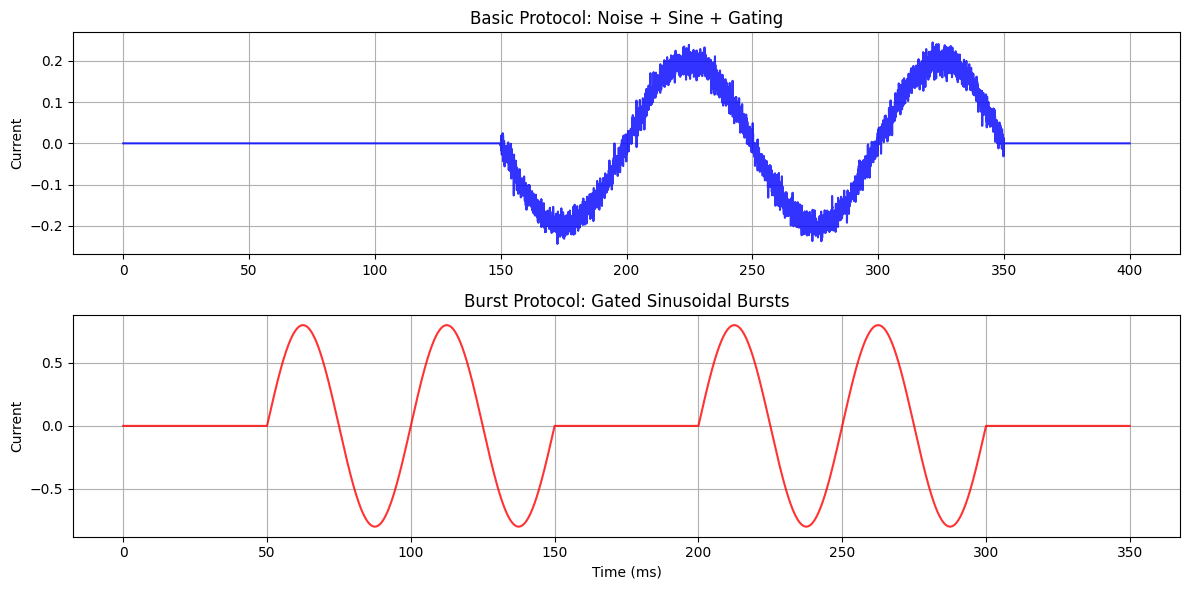

In [16]:
def build_protocol(seed=0):
    """Build a complex stimulation protocol combining multiple input types."""
    noise = braintools.input.WienerProcess(400 * u.ms, sigma=0.15, seed=seed)
    drive = braintools.input.Sinusoidal(0.4, 10 * u.Hz, 400 * u.ms)
    gating = braintools.input.Step([0, 1, 0], [0 * u.ms, 150 * u.ms, 350 * u.ms], 400 * u.ms)
    return (noise + drive).clip(-1.0, 1.0) * gating.scale(0.5)


def build_ramp_burst_protocol(n_bursts=3,
                              burst_duration=50 * u.ms,
                              inter_burst_interval=100 * u.ms):
    """Build a protocol with multiple ramping bursts."""
    total_duration = n_bursts * (burst_duration + inter_burst_interval) - inter_burst_interval

    # Create timing arrays for bursts
    burst_times = []
    for i in range(n_bursts):
        start = i * (burst_duration + inter_burst_interval)
        end = start + burst_duration
        burst_times.extend([start, end])

    # Create alternating on/off pattern
    amplitudes = []
    for i in range(n_bursts):
        amplitudes.extend([0, 1])  # off, on
    amplitudes.append(0)  # final off

    gating = braintools.input.Step(amplitudes, burst_times, total_duration)

    # Create ramping envelope within each burst
    ramp_freq = 20 * u.Hz  # frequency of ramp oscillation
    carrier = braintools.input.Sinusoidal(0.8, ramp_freq, total_duration)

    return carrier * gating


# Test the basic protocol
pipeline = build_protocol(seed=21)
print(f"Basic protocol: {pipeline}")
result = pipeline()
print(f"Result shape: {result.shape}")
print(f"Sample values: {result[:10]}")

# Test the burst protocol
burst_protocol = build_ramp_burst_protocol()
burst_result = burst_protocol()
print(f"\nBurst protocol shape: {burst_result.shape}")
print(f"Burst result range: {jnp.min(burst_result):.3f} to {jnp.max(burst_result):.3f}")

# Visualize both protocols
plt.figure(figsize=(12, 6))

# Basic protocol
plt.subplot(2, 1, 1)
t1 = jnp.arange(len(result)) * 0.05
plt.plot(t1, result, 'b-', alpha=0.8)
plt.title('Basic Protocol: Noise + Sine + Gating')
plt.ylabel('Current')
plt.grid(True)

# Burst protocol
plt.subplot(2, 1, 2)
t2 = jnp.arange(len(burst_result)) * 0.05
plt.plot(t2, burst_result, 'r-', alpha=0.8)
plt.title('Burst Protocol: Gated Sinusoidal Bursts')
plt.xlabel('Time (ms)')
plt.ylabel('Current')
plt.grid(True)

plt.tight_layout()
plt.show()

## Advanced Pipeline Factories

For even more flexibility, you can create parametric factories that generate different protocols based on experimental requirements.

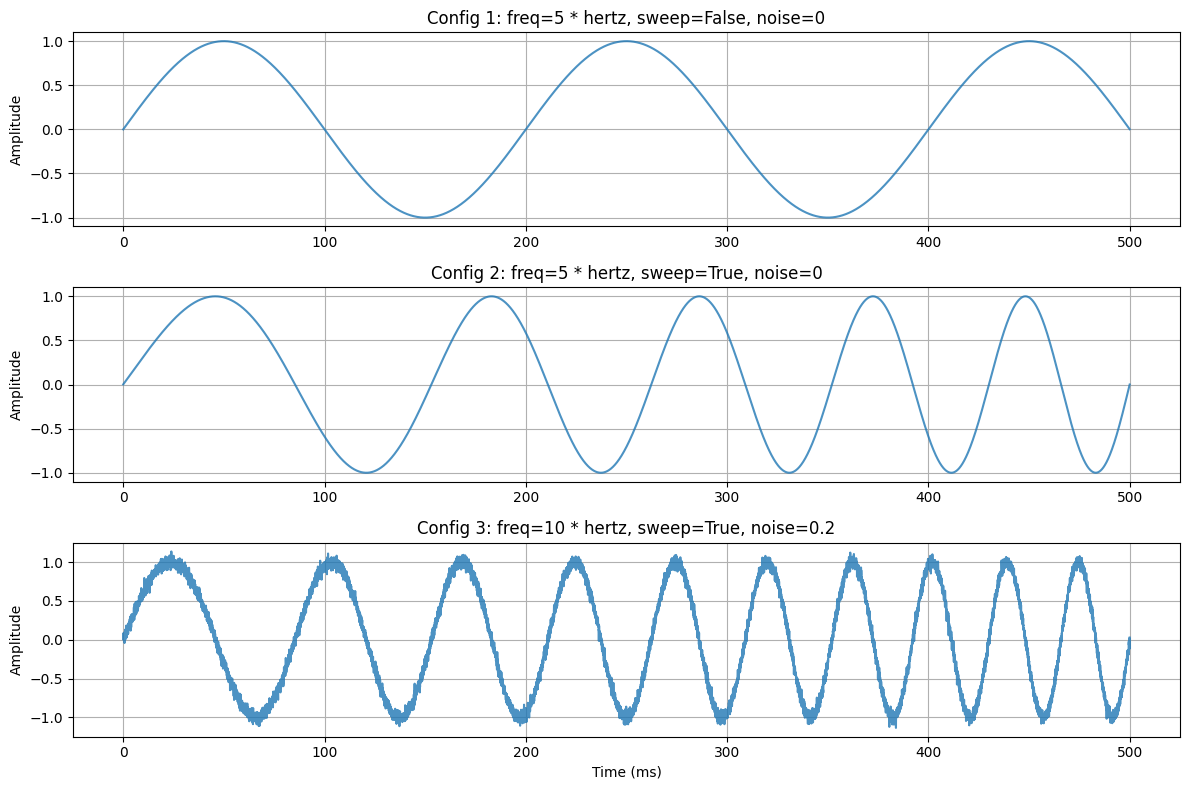

Advanced protocols created successfully!


In [19]:
# Advanced example: Parametric protocol factory
def create_adaptive_protocol(base_freq=5 * u.Hz, freq_sweep=True,
                             noise_level=0.1, duration=500 * u.ms):
    """Create an adaptive protocol with optional frequency sweeping."""
    if freq_sweep:
        # Frequency increases linearly over time
        max_freq = base_freq * 3
        freq_values = braintools.input.ramp(base_freq, max_freq, duration)
        # Create a time-varying sinusoid (chirp-like)
        dt = brainstate.environ.get_dt()
        dt_value = u.split_mantissa_unit(dt)[0]
        total_time = u.Quantity(duration).to(u.ms).mantissa
        n_steps = int(np.ceil(total_time / (dt_value * 1000)))  # Convert to ms

        # Instantaneous phase calculation for varying frequency
        phase = u.math.cumsum(freq_values) * dt * 2 * jnp.pi
        carrier = u.math.sin(phase)
    else:
        carrier = braintools.input.Sinusoidal(1.0, base_freq, duration)()

    if noise_level > 0:
        noise = braintools.input.WienerProcess(duration, sigma=noise_level, seed=42)()
        combined = carrier + noise
    else:
        combined = carrier

    return combined


# Test different configurations
configs = [
    {'base_freq': 5 * u.Hz, 'freq_sweep': False, 'noise_level': 0},
    {'base_freq': 5 * u.Hz, 'freq_sweep': True, 'noise_level': 0},
    {'base_freq': 10 * u.Hz, 'freq_sweep': True, 'noise_level': 0.2}
]

plt.figure(figsize=(12, 8))
for i, config in enumerate(configs):
    signal = create_adaptive_protocol(**config)
    t = jnp.arange(len(signal)) * 0.05

    plt.subplot(3, 1, i + 1)
    plt.plot(t, signal, alpha=0.8)
    title = f"Config {i + 1}: freq={config['base_freq']}, sweep={config['freq_sweep']}, noise={config['noise_level']}"
    plt.title(title)
    plt.ylabel('Amplitude')
    if i == 2:
        plt.xlabel('Time (ms)')
    plt.grid(True)

plt.tight_layout()
plt.show()

print("Advanced protocols created successfully!")

## Best Practices and Tips

When creating custom transformations and pipelines, keep these guidelines in mind:

In [21]:
# Best Practice 1: Always handle units properly
class UnitAwareCustomInput(braintools.input.Input):
    """Example of proper unit handling in custom inputs."""

    def __init__(self, amplitude, duration, time_constant=50 * u.ms):
        super().__init__(duration)
        self.amplitude = amplitude
        self.tau = time_constant

    def _generate(self):
        dt = brainstate.environ.get_dt()
        dt_value, time_unit = u.split_mantissa_unit(dt)
        total = u.Quantity(self.duration).to(time_unit).mantissa
        tau_value = u.Quantity(self.tau).to(time_unit).mantissa

        n_steps = int(np.ceil(total / dt_value))
        t = jnp.arange(n_steps) * dt_value

        # Exponential decay
        return self.amplitude * jnp.exp(-t / tau_value)


# Best Practice 2: Make pipelines parameterizable and reusable
def create_experimental_protocol(protocol_type='standard', **kwargs):
    """Factory function for different experimental protocols."""
    protocols = {
        'standard': lambda: build_protocol(**kwargs),
        'burst': lambda: build_ramp_burst_protocol(**kwargs),
        'adaptive': lambda: create_adaptive_protocol(**kwargs)
    }

    if protocol_type not in protocols:
        raise ValueError(f"Unknown protocol type: {protocol_type}")

    return protocols[protocol_type]()


# Best Practice 3: Document your custom components
def documented_wrapper(func, transformation_name):
    """A well-documented wrapper function."""

    def wrapper(*args, **kwargs):
        # Apply the original function
        result = func(*args, **kwargs)

        # Add metadata for debugging
        if hasattr(result, 'metadata'):
            result.metadata['transformation'] = transformation_name

        return result

    # Preserve original function's docstring
    wrapper.__doc__ = f"""
    Modified version of {func.__name__} with {transformation_name}.
    
    Original docstring:
    {func.__doc__}
    """
    wrapper.__name__ = f"{func.__name__}_with_{transformation_name}"

    return wrapper


# Test the best practices
unit_aware = UnitAwareCustomInput(2.0 * u.nA, 100 * u.ms, 20 * u.ms)
decay_current = unit_aware()

# Test protocol factory
standard_protocol = create_experimental_protocol('standard', seed=123)
burst_protocol = create_experimental_protocol('burst', n_bursts=2)

# Test documented wrapper  
enhanced_ramp = documented_wrapper(braintools.input.ramp, "baseline_correction")
print(f"Enhanced ramp name: {enhanced_ramp.__name__}")
print(f"Has documentation: {enhanced_ramp.__doc__ is not None}")

print("\\nBest practices demonstrated successfully!")
print(f"Decay current range: {u.math.min(decay_current):.3f} to {u.math.max(decay_current):.3f} nA")

Enhanced ramp name: ramp_with_baseline_correction
Has documentation: True
\nBest practices demonstrated successfully!
Decay current range: 0.014 * nampere to 2.000 * nampere nA


## Summary

In this tutorial, you've learned how to:

1. **Subclass `Input`**: Create completely new input types by implementing `_generate()`
2. **Wrap functions**: Modify existing functional helpers with decorators and wrappers
3. **Build pipelines**: Combine multiple inputs into complex, reusable protocols
4. **Follow best practices**: Handle units properly, make code reusable, and document components

These techniques allow you to create sophisticated experimental protocols tailored to your specific research needs. The composable nature of BrainTools inputs means you can mix and match these approaches to build exactly the stimulation patterns your experiments require.

### Key Takeaways:
- Custom `Input` classes are perfect for novel waveform shapes
- Wrapper functions are ideal for modifying existing behaviors  
- Pipeline factories provide flexibility for different experimental conditions
- Always consider units, reusability, and documentation in your custom code